02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [176]:
import warnings
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [177]:
# windows
if os.name == 'nt':
    path = '../../../data/processed/'
    modelpath = '../../src/models/nakagawa/'
else:
    if 'KAGGLE_DATA_PROXY_TOKEN' in os.environ.keys():
        path = '/kaggle/input/processed/'
        modelpath = '/kaggle/input/models/'



# FIXME: PATHを修正すること!!!!


In [178]:
# FIXME: PATH
train_X_path = os.path.join(path,'processed20240618_train_X.csv')
test_X_path =os.path.join(path,'processed20240618_test_X.csv')
train_y_path = os.path.join(path,'processed20240618_train_y.csv')
test_y_path =os.path.join(path,'processed20240618_test_y.csv')
train_path = os.path.join(path,'processed20240618_train.csv')
test_path = os.path.join(path,'processed20240618_test.csv')

In [179]:
# データの読み込み
train_X = pd.read_csv(train_X_path)
train_y = pd.read_csv(train_y_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# 目的変数と説明変数の作成
del train_X['target']
target = train['target']
del train['target']

In [180]:
train_X

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,2015-06-01,C_ID_7f4e51af39,3,3,1,976,3.0,0.0,0.0000,0.000000,0.000000,1.0,0.0,0.000000,1.000000,0.000000,0.0,2.0,1.0,1.0,1.0,1.0,-2.150564,-0.716855,-0.701828,-0.731881,0.015027,0.0,0.000000,0.0,0.0,0.00

In [181]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [182]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['first_active_month','card_id']]
categorical_feats = ['feature_2', 'feature_3']

In [184]:
def model_learning(train,test,modelname):
    # データをKFoldで5分割して学習
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(train))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, test.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                            label=test.iloc[trn_idx],
                            categorical_feature=categorical_feats
                            )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                            label=test.iloc[val_idx],
                            categorical_feature=categorical_feats
                            )

        num_round = 10000
        clf = lgb.train(params=param,
                        train_set=trn_data,
                        num_boost_round=num_round,
                        valid_sets=[val_data],
                        callbacks=[lgb.early_stopping(stopping_rounds=200),
                                lgb.log_evaluation(100)])

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # モデルを保存
        with open(f'{modelpath}{modelname}_{fold_}.pkl', 'wb') as f:
            pickle.dump(clf, f)

    print("CV score: {:<8.5f}".format(root_mean_squared_error(oof, test)))
    return feature_importance_df

# モデルネームを修正すること！！！

In [185]:
# FIXME: train_Xデータの学習
X_train_feature_importance_df = model_learning(train_X,train_y,'train_X_model_20240618')


fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.77381
[200]	valid_0's rmse: 3.73328
[300]	valid_0's rmse: 3.71548
[400]	valid_0's rmse: 3.70662
[500]	valid_0's rmse: 3.70232
[600]	valid_0's rmse: 3.69875
[700]	valid_0's rmse: 3.69685
[800]	valid_0's rmse: 3.69539
[900]	valid_0's rmse: 3.69432
[1000]	valid_0's rmse: 3.69378
[1100]	valid_0's rmse: 3.69327
[1200]	valid_0's rmse: 3.69316
[1300]	valid_0's rmse: 3.69302
[1400]	valid_0's rmse: 3.69287
[1500]	valid_0's rmse: 3.6929
[1600]	valid_0's rmse: 3.69279
[1700]	valid_0's rmse: 3.69279
[1800]	valid_0's rmse: 3.69332
Early stopping, best iteration is:
[1646]	valid_0's rmse: 3.69268
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.72
[200]	valid_0's rmse: 3.68073
[300]	valid_0's rmse: 3.66397
[400]	valid_0's rmse: 3.65663
[500]	valid_0's rmse: 3.65285
[600]	valid_0's rmse: 3.65058
[700]	valid_0's rmse: 3.64913
[800]	valid_0's rmse: 3.64828
[900]	v

# モデルネームを修正すること!!!!

In [186]:
# すべてのtrainデータの学習
feature_importance_df = model_learning(train,target,'train_all_model_20240618')


fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7764
[200]	valid_0's rmse: 3.72902
[300]	valid_0's rmse: 3.70567
[400]	valid_0's rmse: 3.6934
[500]	valid_0's rmse: 3.68606
[600]	valid_0's rmse: 3.68123
[700]	valid_0's rmse: 3.6781
[800]	valid_0's rmse: 3.6764
[900]	valid_0's rmse: 3.67506
[1000]	valid_0's rmse: 3.67407
[1100]	valid_0's rmse: 3.67329
[1200]	valid_0's rmse: 3.67282
[1300]	valid_0's rmse: 3.67255
[1400]	valid_0's rmse: 3.67224
[1500]	valid_0's rmse: 3.67202
[1600]	valid_0's rmse: 3.67194
[1700]	valid_0's rmse: 3.67166
[1800]	valid_0's rmse: 3.67179
[1900]	valid_0's rmse: 3.67197
Early stopping, best iteration is:
[1737]	valid_0's rmse: 3.67141
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70512
[200]	valid_0's rmse: 3.66175
[300]	valid_0's rmse: 3.64053
[400]	valid_0's rmse: 3.63
[500]	valid_0's rmse: 3.62451
[600]	valid_0's rmse: 3.62153
[700]	valid_0's rmse: 3.61946
[800]	val

In [187]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
cols


Index(['new_purchase_date_max', 'auth_purchase_date_max',
       'auth_month_diff_mean', 'hist_month_diff_mean',
       'new_purchase_amount_max', 'new_purchase_date_ptp',
       'new_purchase_month_mean', 'auth_purchase_date_ptp',
       'new_month_lag_mean', 'purchase_amount_max_mean', 'auth_month_lag_mean',
       'new_purchase_date_min', 'auth_purchase_date_min',
       'auth_purchase_month_std', 'new_purchase_amount_std',
       'auth_category_1_sum', 'auth_category_1_mean', 'authorized_flag_mean',
       'hist_purchase_amount_sum', 'hist_installments_sum'],
      dtype='object', name='feature')

In [190]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:10].index)
cols

Index(['new_purchase_date_max', 'auth_purchase_date_max',
       'auth_month_diff_mean', 'hist_month_diff_mean',
       'new_purchase_amount_max', 'new_purchase_date_ptp',
       'new_purchase_month_mean', 'auth_purchase_date_ptp',
       'new_month_lag_mean', 'purchase_amount_max_mean'],
      dtype='object', name='feature')

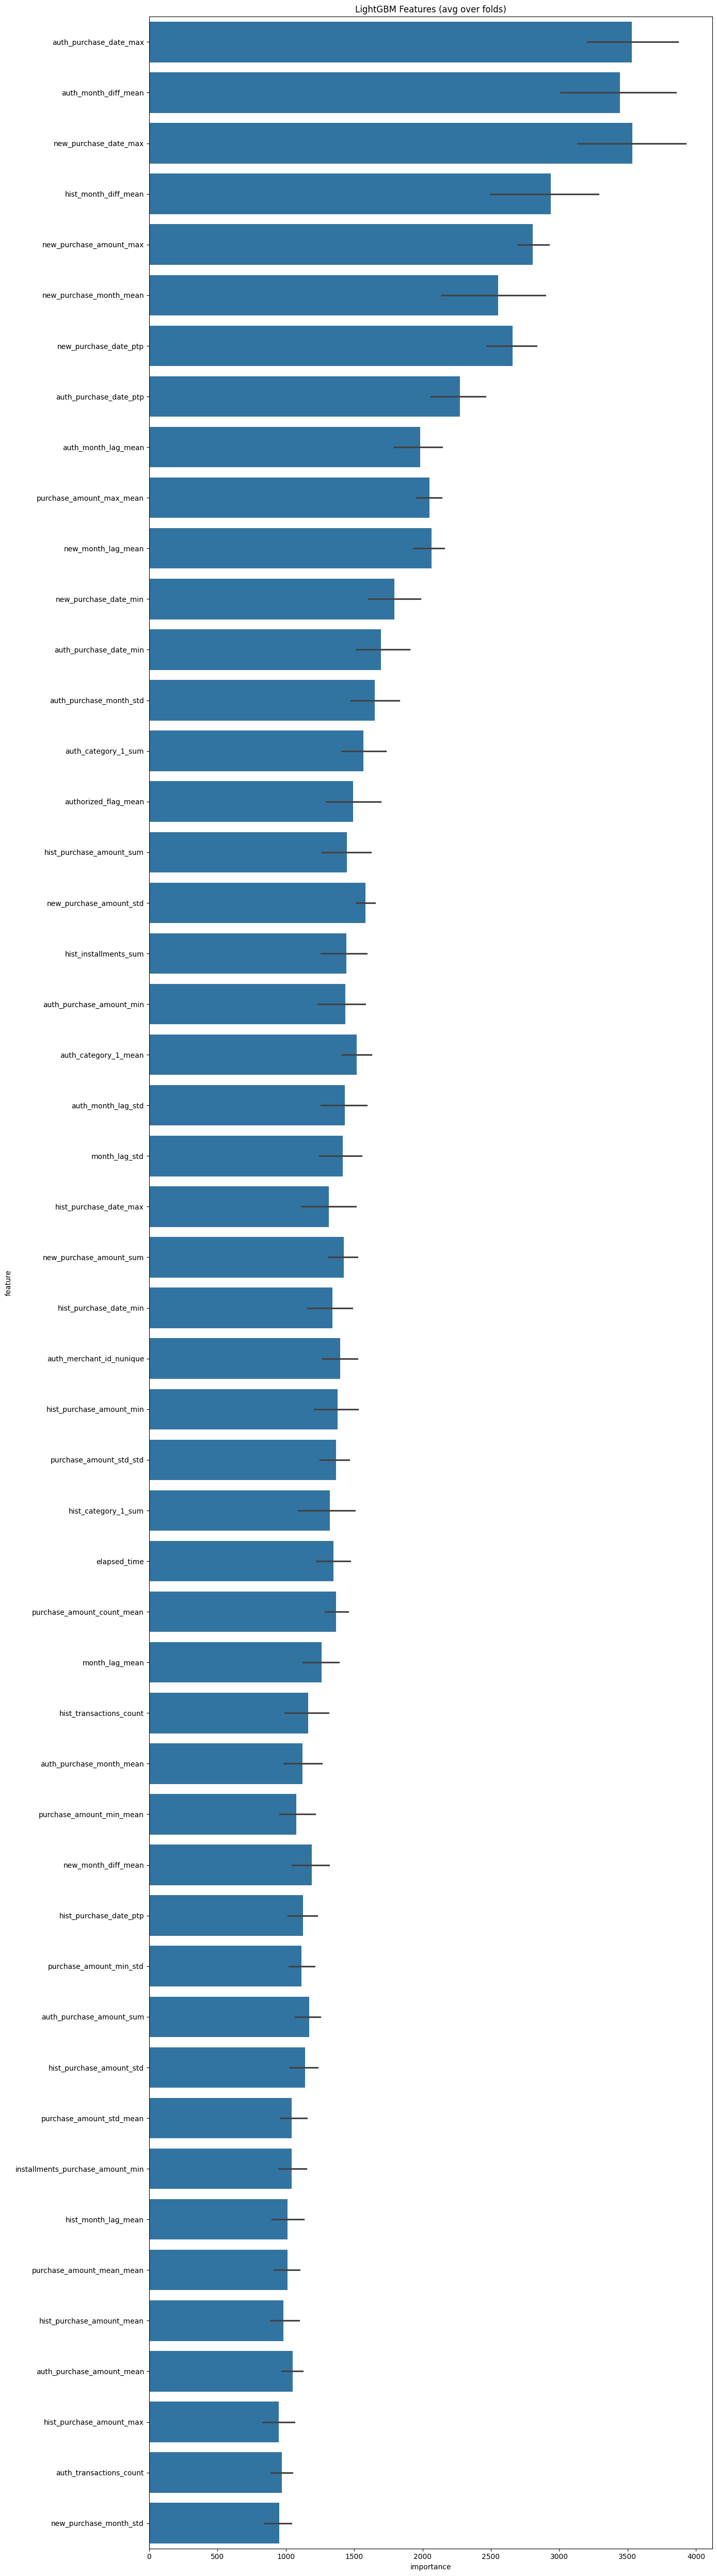

In [188]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')